# Hierarchial Generation of Moelcules

In this tutorial, we will load a pre-trained model which hierarchically generates molecules using graph motifs. Prior work on generating molecules tends to use small units such as atoms and simpler cycles, but this limits the graph generation to smaller molecules. In Hierarchical Generation of Molecular Graphs using Structural Motifs (https://arxiv.org/abs/2002.03230), Jin et. al. proposed a method to use larger and more flexible motifs as units. 

Motifs are produced seperately before the generation process based on frequenclty occuring substructures. To create motifs, a molecule is decomposed into fragments by breaking bridge bonds that wouldn't violate chemical validity. A fragment is selected as a motif if it occurs in the training set more than a set amount of times. If the fragment is not selected, then break them into rings and bonds and select as a motif in the original molecule. This allows for the creating of a vocabulary of motifs.

The molecular generation model is an extension of the VAE by using a hierarchial encoder and decoder. During the generation step, the decoder adds a motif and attachment cofiguration and then decides how it should be added to the current graph. Thus, the encoder needs to learn to represent molecules at different scales. So, a molecule is represented as a hiearchial graph with 3 levels: motif, attachment, and atom. There are also edges connecting atoms and motifs between different layers and by using a hiearchial message passing network (MPN), the molecule is encoded.

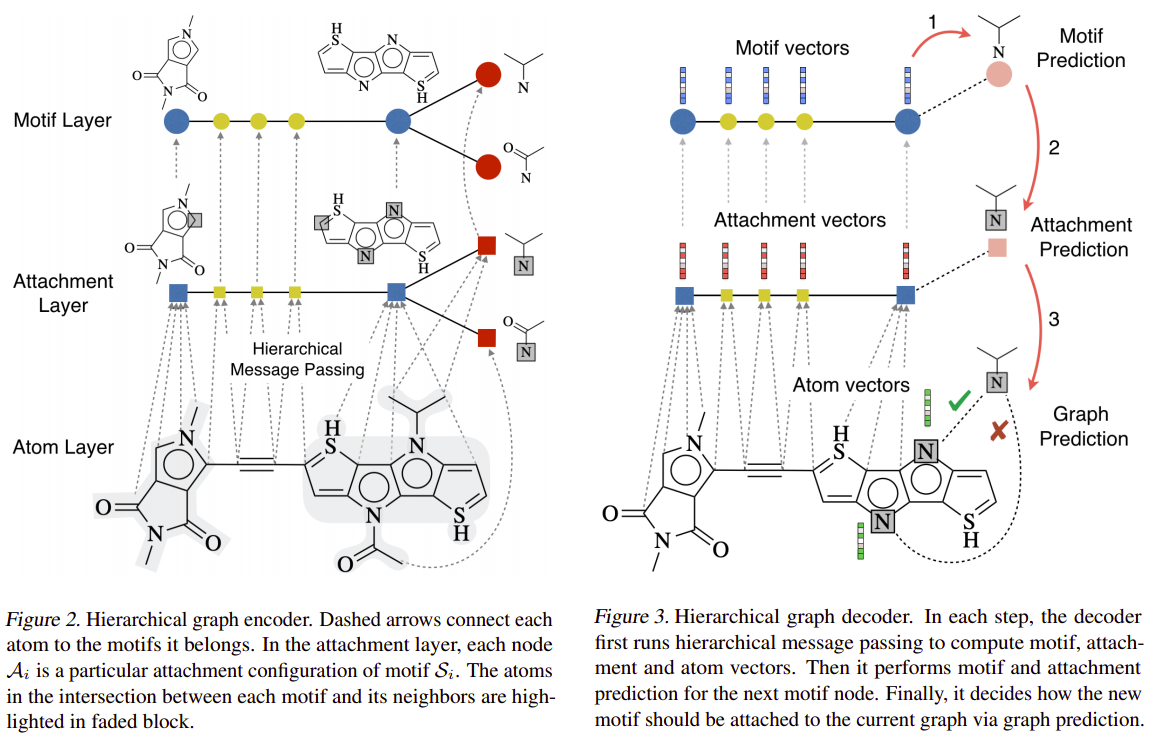


## RDKit Version

An important caveat is that this code does not work with the latest version of RDKit. Currently, it is known that it works with RDKit version >= 2019.03 and <= 2020.09.5

## Colab
This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Generating_molecules_with_MolGAN.ipynb)

## Setup

The original repository had to be modified to allow running on a cpu, so we are using a fork

In [1]:
%cd drive/MyDrive
!git clone https://github.com/saithat/hgraph2graph.git

In [2]:
%cd hgraph2graph

In [3]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

In [4]:
#!pip install chemprop

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import OrderedDict

import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw


import math, random, sys
import numpy as np
from tqdm import tqdm

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader

In [7]:
#import finetune_generator
#from finetune_generator import Chemprop
import hgraph
from hgraph import *

ModuleNotFoundError: No module named 'hgraph'

Original repository uses extensive command line arguments, so to modify as least as possible, we define our own Args class to fit into existing structure

In [ ]:
class Args():
    def __init__(self):
        self.vocab = 'data/chembl/vocab.txt'
        self.atom_vocab = common_atom_vocab
        self.model = 'ckpt/chembl-pretrained/model.ckpt'
        self.seed = 7
        self.nsample = 100
        self.rnn_type = 'LSTM'
        self.hidden_size = 250
        self.embed_size = 250
        self.batch_size = 50
        self.latent_size = 32
        self.depthT = 15
        self.depthG = 15
        self.diterT = 1
        self.diterG = 3
        self.dropout = 0.0

In [ ]:
args = Args()

Open the pre-defined motif vocabulary

In [ ]:
vocab = [x.strip("\r\n ").split() for x in open("data/chembl/vocab.txt")]
args.vocab = PairVocab(vocab, cuda=False)

Code in existing repo was designed to work with Nvidia GPUs, so we modified to allow working with cpu as well in case a Nvidia GPU is not available

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Load pretrained model

In [ ]:
model = HierVAE(args).to(device)
if not torch.cuda.is_available() == 'cpu':
    model.load_state_dict(torch.load(args.model, map_location=torch.device('cpu'))[0])
else:
    model.load_state_dict(torch.load(args.model)[0])
model.eval()

In [ ]:
torch.manual_seed(args.seed)
random.seed(args.seed)

In [ ]:
nmols_smiles = []

Sample molecules from the model

In [ ]:
with torch.no_grad():
    for _ in tqdm(range(args.nsample // args.batch_size)):
        smiles_list = model.sample(args.batch_size, greedy=True)
        for _,smiles in enumerate(smiles_list):
            print(smiles)
            nmols_smiles.append(smiles)

Keep only the unique molecules and convert to Rdkit Mols

In [ ]:
nmols_smiles_unique = list(OrderedDict.fromkeys(nmols_smiles))
nmols_viz = [Chem.MolFromSmiles(x) for x in nmols_smiles_unique]

In [ ]:
img = Draw.MolsToGridImage(nmols_viz[0:100], molsPerRow=5, subImgSize=(250, 250), maxMols=100, legends=None, returnPNG=False)

In [ ]:
img